In [16]:
library(parallel)
library(lme4)
library(mgcv)
library(xtable)
library(pROC)

In [3]:
PATH_TO_DATA = '/Users/rachel/Documents/research/hla_ii/clean_matrices/'

In [116]:
#Format data
tissue <- read.csv(paste(PATH_TO_DATA, 'patient_tissues.csv', sep=""),header=TRUE)
mut <- read.csv(paste(PATH_TO_DATA, 'combined_classes/patient_mutations.csv', sep=""),header=TRUE)
aff1 <- read.csv(paste(PATH_TO_DATA, 'combined_classes/patient_affinities.class_i.csv', sep=""),header=TRUE)
aff2 <- read.csv(paste(PATH_TO_DATA, 'combined_classes/patient_affinities.class_ii.csv', sep=""),header=TRUE)
patient <- as.character(mut[,1])
mut <- as.matrix(mut[,-1])
aff1 <- as.matrix(aff1[,-1])
aff2 <- as.matrix(aff2[,-1])
rownames(mut) <- rownames(aff1) <- rownames(aff2) <- patient

In [117]:
# probably need to update
y= as.vector(mut); x= as.vector(aff1); z= as.vector(aff2)
gene= rep(colnames(mut),each=nrow(mut))
pat= rep(rownames(mut),ncol(mut))
nmut= colSums(mut)
sel= gene %in% names(nmut[nmut>=5])

In [142]:
sampled_pats = head(unique(pat), 1000)
#sampled_pats = unique(pat)

In [143]:
sel_pat = pat %in% sampled_pats 

In [144]:
head(y[sel&sel_pat])

[1] 1 0 0 0 0 0

In [145]:
df = data.frame(y[sel&sel_pat], x[sel&sel_pat], z[sel&sel_pat], pat[sel&sel_pat])
colnames(df)<-c('y', 'x', 'z', 'pat')

In [146]:
nrow(df)

[1] 165000

Testing

In [ ]:
# both MHC-I and MHC-II
all_labels=NULL
all_predictions=NULL
for (i in 1:3)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(df), round(nrow(df)/10))
    # to test the model
    DataC1=df[sample_rows, ]
    # to train the model
    DataCV=df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ z + log(x) + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_df = data.frame(all_labels, all_predictions)
colnames(results_df)<-c('label', 'predicted')
# probabilities
results_df$predicted_prob<-exp(results_df$predicted)
# labels as factors
results_df$label_fact <- factor(results_df$label)

roc_obj <- roc(results_df$label_fact, results_df$predicted_prob)

In [ ]:
# only MHC-I
all_labels=NULL
all_predictions=NULL
for (i in 1:3)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(df), round(nrow(df)/10))
    # to test the model
    DataC1=df[sample_rows, ]
    # to train the model
    DataCV=df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ log(x) + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_dfI = data.frame(all_labels, all_predictions)
colnames(results_dfI)<-c('label', 'predicted')
# probabilities
results_dfI$predicted_prob<-exp(results_dfI$predicted)
# labels as factors
results_dfI$label_fact <- factor(results_dfI$label)

roc_objI <- roc(results_dfI$label_fact, results_dfI$predicted_prob)

In [ ]:
# only MHC-II
all_labels=NULL
all_predictions=NULL
for (i in 1:3)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(df), round(nrow(df)/10))
    # to test the model
    DataC1=df[sample_rows, ]
    # to train the model
    DataCV=df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ z + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_dfII = data.frame(all_labels, all_predictions)
colnames(results_dfII)<-c('label', 'predicted')
# probabilities
results_dfII$predicted_prob<-exp(results_dfII$predicted)
# labels as factors
results_dfII$label_fact <- factor(results_dfII$label)

roc_objII <- roc(results_dfII$label_fact, results_dfII$predicted_prob)

All patients, >=20 times mutated

In [161]:
auc_summary <-vector("list", 3)
auc_summary[[1]] <- c(ci(roc_obj))
auc_summary[[2]] <- c(ci(roc_objI))
auc_summary[[3]] <- c(ci(roc_objII))
auc_df <- data.frame(auc_summary)
colnames(auc_df) <- c('Both', 'Only_I', 'Only_II')
rownames(auc_df) <- c('low_CI', 'AUC', 'high_CI')

In [162]:
auc_df

,Both,Only_I,Only_II
low_CI,0.5818658,0.5867969,0.5598927
AUC,0.6039991,0.6093278,0.5807849
high_CI,0.6261323,0.6318586,0.6016771


In [160]:
print(c(ci(roc_obj)))
print(c(ci(roc_objI)))
print(c(ci(roc_objII)))

[1] 0.5818658 0.6039991 0.6261323
[1] 0.5867969 0.6093278 0.6318586
[1] 0.5598927 0.5807849 0.6016771


In [159]:
print(c(auc(roc_obj), ci(roc_obj)))
print(c(auc(roc_objI), ci(roc_objI)))
print(c(auc(roc_objII), ci(roc_objII)))

[1] 0.6039991 0.5818658 0.6039991 0.6261323
[1] 0.6093278 0.5867969 0.6093278 0.6318586
[1] 0.5807849 0.5598927 0.5807849 0.6016771


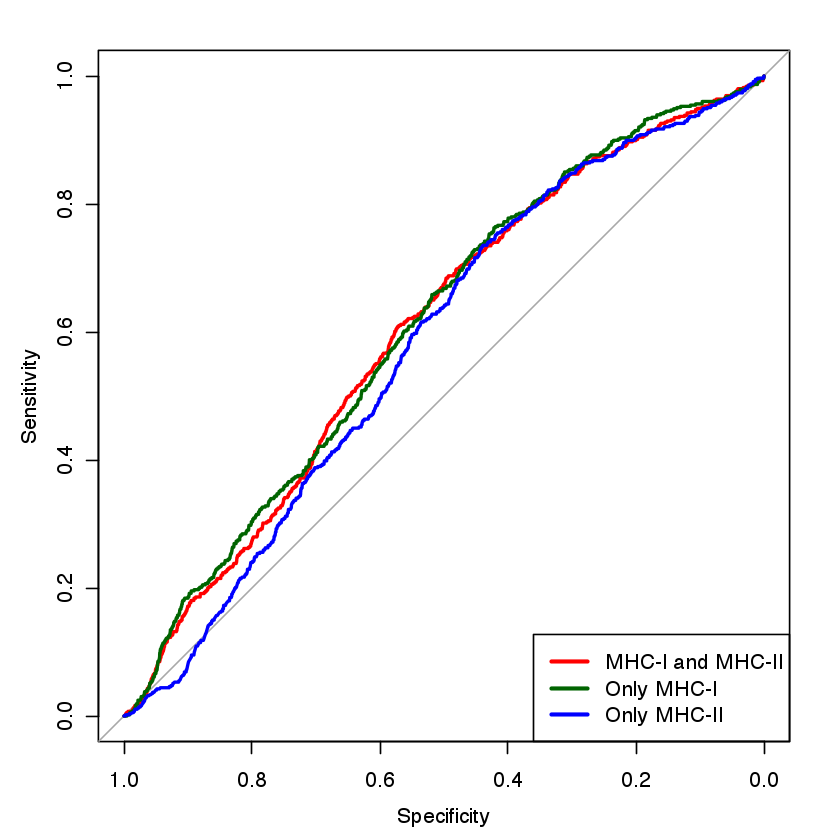

In [163]:
plot(roc_obj, col='red')
plot(roc_objI, col='darkgreen', add=TRUE)
plot(roc_objII, col='blue', add=TRUE)
legend("bottomright", 
  legend = c("MHC-I and MHC-II", "Only MHC-I", "Only MHC-II"),
      col=c('red','darkgreen', 'blue'),
      lwd=c(2.5,2.5))

1000 patients, >= 5 times mutated

In [74]:
print(c(auc(roc_obj), ci(roc_obj)))
print(c(auc(roc_objI), ci(roc_objI)))
print(c(auc(roc_objII), ci(roc_objII)))

[1] 0.6242666 0.6018088 0.6242666 0.6467245
[1] 0.5892100 0.5671871 0.5892100 0.6112330
[1] 0.5973600 0.5754979 0.5973600 0.6192221


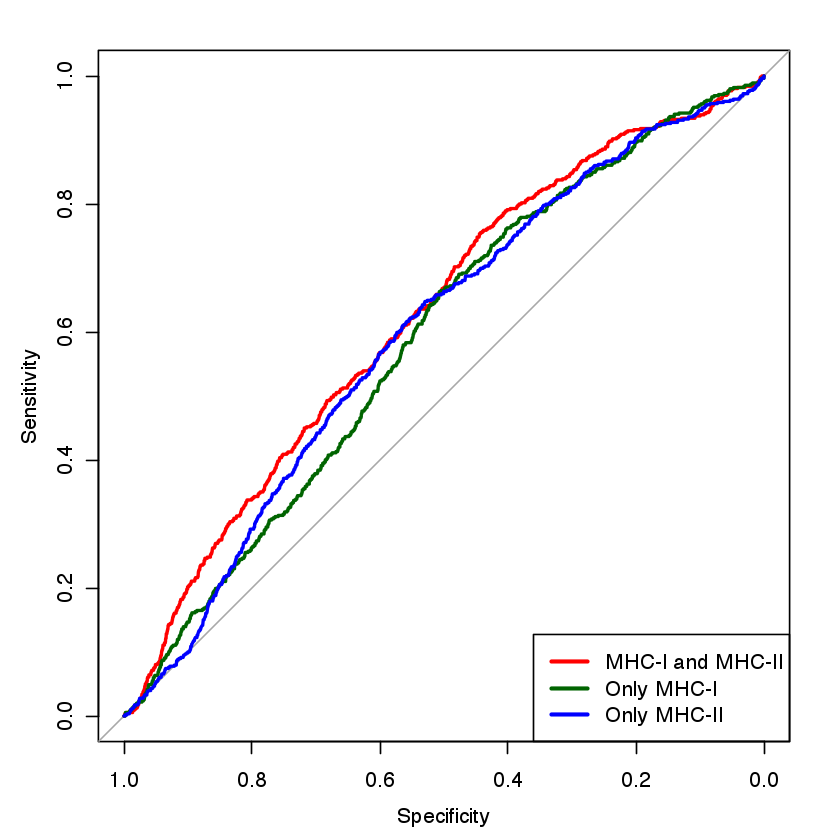

In [76]:
plot(roc_obj, col='red')
plot(roc_objI, col='darkgreen', add=TRUE)
plot(roc_objII, col='blue', add=TRUE)
legend("bottomright", 
  legend = c("MHC-I and MHC-II", "Only MHC-I", "Only MHC-II"),
      col=c('red','darkgreen', 'blue'),
      lwd=c(2.5,2.5))

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in plot.window(...): need finite 'xlim' values


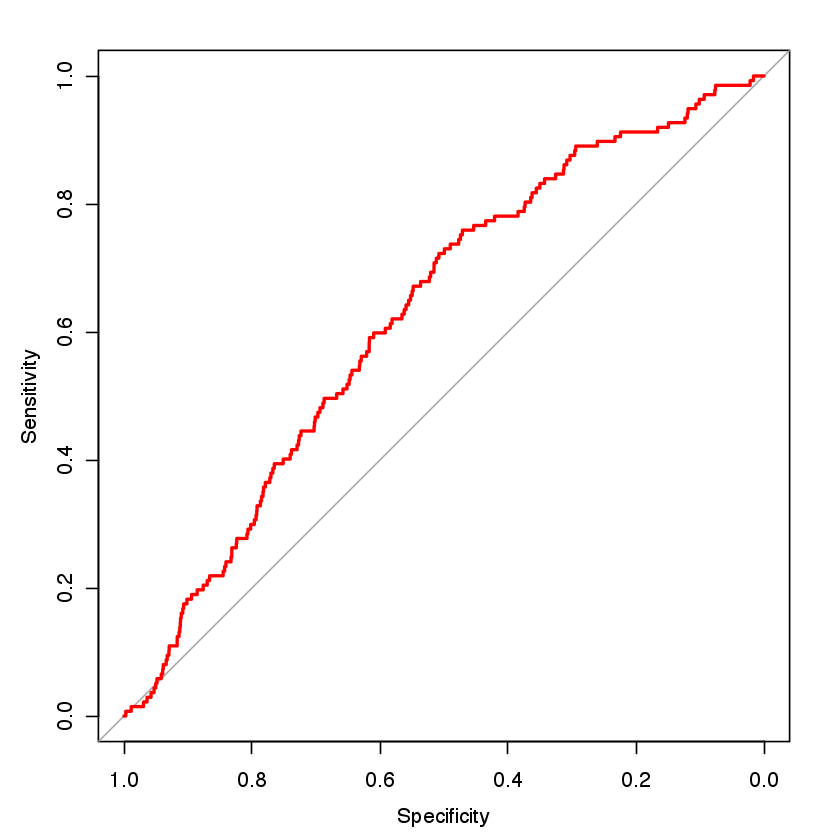

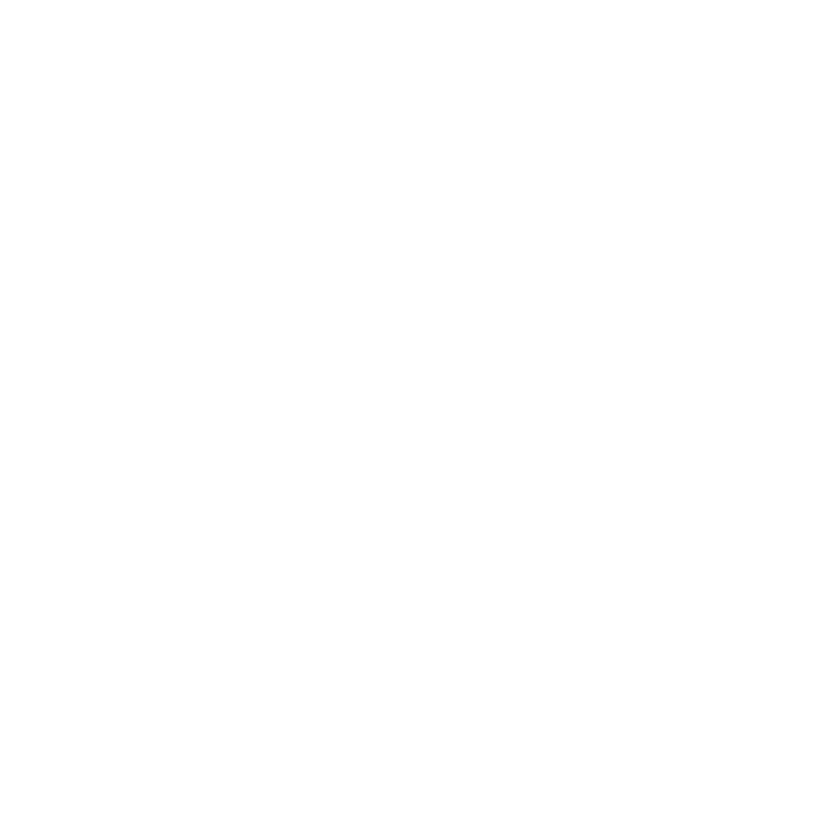

In [54]:
plot(roc_obj, col='red', xlim=c(1, 0), ci=TRUE, ci.type="bars") #+ plot(ci.thresholds(roc_obj))

The real thing

In [ ]:
# both MHC-I and MHC-II
all_labels=NULL
all_predictions=NULL
for (i in 1:3)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(df), round(nrow(df)/10))
    # to test the model
    DataC1=df[sample_rows, ]
    # to train the model
    DataCV=df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ log(z) + log(x) + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_df = data.frame(all_labels, all_predictions)
colnames(results_df)<-c('label', 'predicted')
# probabilities
results_df$predicted_prob<-exp(results_df$predicted)
# labels as factors
results_df$label_fact <- factor(results_df$label)

plot(roc(results_df$predicted_prob, results_df$label_fact))